In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
data_postulantes = pd.read_csv('data-tp/postulantes_genero_edad_limpio.csv')
data_vistas = pd.read_csv('data-tp/vistas_limpio.csv')
data_detalles = pd.read_csv('data-tp/avisos_detalles.csv')


In [2]:
postulantes_vistas = pd.merge(data_postulantes, data_vistas, on='idpostulante', how= 'inner')

In [5]:
postulantes_vistas['fecha_nacimiento_dt'] = pd.to_datetime(postulantes_vistas['fechanacimiento'], errors= 'coerce')
postulantes_vistas['age'] = postulantes_vistas['fecha_nacimiento_dt'].apply(lambda x: 2018 - x.year)


In [6]:
#vistas_counts = postulantes_vistas['idpostulante'].value_counts().to_frame()
#postulantes_vistas_sd = postulantes_vistas.drop_duplicates('idpostulante')
postulantes_vistas_count = postulantes_vistas.groupby(['idpostulante', 'age']).count().reset_index()

In [7]:
postulantes_vistas_count = postulantes_vistas_count[['idpostulante','age','fechanacimiento']]
postulantes_vistas_count.columns = ['id_postulante','age','avisos_vistos']

In [8]:
postulantes_avisos_mean = postulantes_vistas_count.groupby('age').mean().reset_index()
postulantes_avisos_mean.columns = ['age','avisos_vistos_mean']

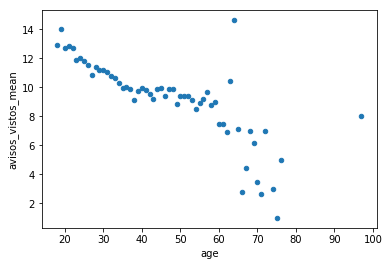

In [9]:
%matplotlib inline
postulantes_avisos_mean.plot.scatter('age','avisos_vistos_mean')


## Grafico la cantidad de avisos promedio de la gente menor a 40 años, discriminado por sexo.

In [29]:
postulantes_sexo_edad = postulantes_vistas.groupby(['idpostulante', 'sexo','age']).count().reset_index()[['sexo','idAviso','age']]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad[postulantes_sexo_edad['age'] < 40]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad_men_30.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_30.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_30.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

# El plot quedo gigante, quizas se puede particionar mas todavia.

NameError: name 'postulantes_vistas' is not defined

## idem arriba, para la gente entre 40-70 años.

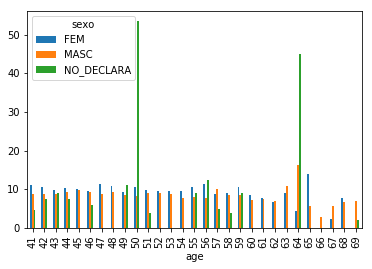

In [16]:
postulantes_sexo_edad_men_70 = postulantes_sexo_edad[(postulantes_sexo_edad['age'] > 40) & (postulantes_sexo_edad['age']<70)]
postulantes_sexo_edad_men_70 = postulantes_sexo_edad_men_70.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_70.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_70.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

In [4]:
data_carreras = pd.read_csv('data/fiuba_1_postulantes_educacion.csv',error_bad_lines=False)


## Obtengo el titulo mas "alto" de cada id.

In [31]:
carrers_by_priority = ['Secundario','Terciario/Técnico','Otro','Universitario','Posgrado','Master','Doctorado']
def get_higher_carrer(serie):
    high = 0
    for index in range(len(carrers_by_priority)):
        for carrer in serie['nombre']:
            if(carrers_by_priority[index] == carrer):
                high = index if index > high else high
    return carrers_by_priority[high]

data_carreras_fil = data_carreras.groupby('idpostulante').agg(get_higher_carrer).reset_index()[['idpostulante','nombre']]

In [33]:
data_carreras_fil = data_carreras.merge(data_carreras_fil, how = 'left', on=['idpostulante','nombre'])

In [35]:
data_carreras_univ = data_carreras_fil[data_carreras_fil['nombre'] == 'Universitario']


## ¿Buscan más trabajo las personas que están estudiando una carrera o los que se graduaron?

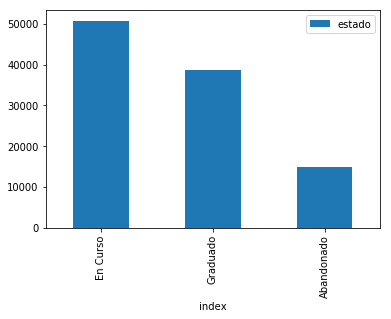

In [51]:
data_carreras_univ['estado'].value_counts().to_frame().reset_index().plot.bar(x='index',y='estado')

In [5]:
postulantes_vistas_detalles = postulantes_vistas.merge(data_detalles, on = 'idAviso', how ='inner')

In [14]:
postulantes_sexo_area = postulantes_vistas_detalles.groupby(['nombre_area','sexo']).count().reset_index()[['nombre_area','sexo','idpostulante']]

In [ ]:
postulantes_sexo_area = postulantes_sexo_area[postulantes_sexo_area['']]

In [22]:
postulantes_sexo_area#.pivot(index = 'nombre_area', columns= 'sexo', values='idpostulante').plot(kind='bar')

,nombre_area,sexo,idpostulante
0,Abastecimiento,FEM,932
1,Abastecimiento,MASC,2013
2,Abastecimiento,NO_DECLARA,9
3,Administracion de Seguros,FEM,714
4,Administracion de Seguros,MASC,525
5,Administración,FEM,64563
6,Administración,MASC,36393
7,Administración,NO_DECLARA,288
8,Administración de Base de Datos,FEM,34
9,Administración de Base de Datos,MASC,29
